# From MNIST to the Real World: Handwritten Digit Recognition under Domain Shift

## Project Overview

This project explores how a Convolutional Neural Network (CNN) trained on the MNIST dataset performs when applied to **real-world digit images**, such as digitally drawn digits and photographed handwritten digits.

Although MNIST is a widely used benchmark for handwritten digit recognition, it represents a highly controlled and clean data distribution. In contrast, real-world images often differ significantly in lighting conditions, stroke thickness, noise, alignment, and background complexity. This mismatch between training and deployment data, known as **domain shift**, can lead to substantial performance degradation.

The objectives of this project are to:
- Evaluate the generalization ability of an MNIST-trained CNN on real-world images
- Design an OpenCV-based preprocessing pipeline to convert real images into MNIST-like inputs
- Analyze prediction failures and confidence behavior under domain shift
- Improve real-world performance through fine-tuning and mixed-domain training (MNIST + real-world data)

The project follows a complete and realistic machine learning workflow:
**baseline → domain shift → analysis → adaptation → improvement**.



#####################################################################


## Phase 1 — MNIST Baseline: Loading, Training, and Evaluation

The first phase of this project establishes a **baseline model** using the MNIST dataset. MNIST consists of grayscale images of handwritten digits (0–9), each with a resolution of 28×28 pixels, and is commonly used as a benchmark for image classification tasks.

### Dataset Preparation
The MNIST dataset is loaded using standard PyTorch utilities and split into training and test sets.  
Each image is:
- normalized using the official MNIST mean and standard deviation,
- reshaped to match the CNN input format `(1 × 28 × 28)`.

This ensures stable training and compatibility with convolutional layers.

### Model Architecture
A Convolutional Neural Network (CNN) is designed for digit classification.  
The network consists of:
- convolutional layers for spatial feature extraction,
- non-linear activations and pooling layers for robustness,
- fully connected layers for classification into 10 digit classes.

This architecture is intentionally kept simple to focus on **generalization behavior** rather than architectural complexity.

### Training Procedure
The model is trained on the MNIST training set using:
- cross-entropy loss,
- the Adam optimizer,
- mini-batch gradient descent.

Training is performed for multiple epochs, while monitoring:
- training loss,
- training accuracy,
- validation (test) accuracy.

### Evaluation
After training, the model is evaluated on the MNIST test set to measure baseline performance.  
As expected, the CNN achieves **high accuracy** on MNIST, confirming that the model is capable of learning discriminative digit features under ideal, well-controlled conditions.

This baseline serves as a reference point for later phases, where the same model is tested on **real-world digit images** that differ significantly from the MNIST data distribution.


In [46]:
# --------------------------------------------------
# Imports & environment setup
# --------------------------------------------------
# torch        → Core PyTorch library for tensors and neural networks
# DataLoader  → Utility for efficient batching, shuffling, and loading data
# datasets    → Ready-to-use datasets (e.g., MNIST)
# transforms  → Image preprocessing and normalization pipelines

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# --------------------------------------------------
# Numerical & utility libraries
# --------------------------------------------------
# numpy  → Numerical operations and array handling
# random → Reproducibility and controlled randomness

import numpy as np
import random



In [47]:
# --------------------------------------------------
# Reproducibility
# --------------------------------------------------
# Setting random seeds ensures that:
# - data shuffling
# - weight initialization
# - stochastic operations
# produce consistent results across runs.
#
# This is essential for debugging, fair comparisons,
# and reproducible experiments.

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("Random seed set to:", SEED)


Random seed set to: 42


In [48]:
# --------------------------------------------------
# Hyperparameters & paths
# --------------------------------------------------
# BATCH_SIZE  → Number of samples processed per training iteration
# DATA_DIR    → Local directory where the MNIST dataset is stored/downloaded
# NUM_CLASSES → Number of output classes (digits 0–9)

BATCH_SIZE = 128
DATA_DIR = "./data"
NUM_CLASSES = 10

print("Batch size:", BATCH_SIZE)


Batch size: 128


In [49]:
# --------------------------------------------------
# Data preprocessing transforms
# --------------------------------------------------
# ToTensor():
#   - Converts PIL images to PyTorch tensors
#   - Scales pixel values from [0, 255] to [0, 1]
#
# Normalize():
#   - Standardizes inputs using the MNIST mean and standard deviation
#   - Improves numerical stability and training convergence

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

print("Transforms ready")


Transforms ready


In [50]:
# --------------------------------------------------
# Load MNIST dataset
# --------------------------------------------------
# train=True   → Training split (60,000 images)
# train=False  → Test split (10,000 images)
# download=True → Downloads the dataset if not already present locally

train_dataset = datasets.MNIST(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform
)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 60000
Test samples: 10000


In [51]:
# --------------------------------------------------
# Create DataLoaders
# --------------------------------------------------
# DataLoader handles:
# - batching
# - shuffling
# - efficient data access during training and evaluation
#
# shuffle=True  → important during training to reduce bias
# shuffle=False → evaluation must be deterministic and repeatable

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))


Train batches: 469
Test batches: 79


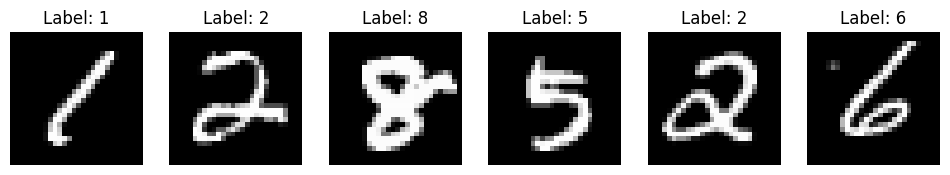

In [52]:
# --------------------------------------------------
# Visualize sample images
# --------------------------------------------------
# This sanity check helps verify that:
# - The dataset is loaded correctly
# - Image-label pairs are aligned
# - Normalization and preprocessing did not distort the images
#
# Visual inspection at this stage can catch data issues
# before training begins.

import matplotlib.pyplot as plt

# Fetch a single batch from the training loader
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    axes[i].imshow(images[i].squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis("off")

plt.show()


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [54]:
# --------------------------------------------------
# CNN model definition (MNIST)
# --------------------------------------------------
# Input shape:  (batch_size, 1, 28, 28)
# Output:       (batch_size, 10) logits (unnormalized class scores)
#
# Why use a CNN?
# - Convolutions learn local spatial patterns (edges, curves, strokes)
# - Weight sharing reduces the number of parameters
# - Pooling adds robustness to small translations
# - Significantly more effective than a plain MLP for image data

import torch.nn as nn
import torch.nn.functional as F

class MNIST_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # --------------------------------------------------
        # Convolutional block 1
        # --------------------------------------------------
        # Input:  1 channel (grayscale)
        # Output: 32 feature maps
        # kernel_size=3 with padding preserves spatial resolution
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=3,
            padding=1
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)   # 28×28 → 14×14

        # --------------------------------------------------
        # Convolutional block 2
        # --------------------------------------------------
        # Input:  32 feature maps
        # Output: 64 feature maps
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)   # 14×14 → 7×7

        # After the convolutional blocks:
        # Feature map size = 64 × 7 × 7 = 3136 features per sample
        self.flatten = nn.Flatten()

        # --------------------------------------------------
        # Fully connected classification head
        # --------------------------------------------------
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(p=0.3)   # Reduces overfitting
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # ----- Feature extraction -----
        x = self.conv1(x)       # (B, 32, 28, 28)
        x = F.relu(x)
        x = self.pool1(x)       # (B, 32, 14, 14)

        x = self.conv2(x)       # (B, 64, 14, 14)
        x = F.relu(x)
        x = self.pool2(x)       # (B, 64, 7, 7)

        # ----- Classification -----
        x = self.flatten(x)     # (B, 3136)
        x = self.fc1(x)         # (B, 128)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)         # (B, 10)

        # IMPORTANT:
        # We return raw logits (no softmax).
        # CrossEntropyLoss applies LogSoftmax internally.
        return x

# Create the model and move it to the selected device (CPU or GPU)
model = MNIST_CNN(num_classes=NUM_CLASSES).to(device)
print(model)


MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [55]:
# --------------------------------------------------
# Quick shape sanity check (important)
# --------------------------------------------------
# We pass a single batch through the model to verify that:
# - Input tensor shapes match the model's expectations
# - Output logits have the correct dimensionality
#
# This simple check can catch many common implementation
# errors before training begins.

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():
    logits = model(images)

print("Input batch shape:", images.shape)   # Expected: (B, 1, 28, 28)
print("Output logits shape:", logits.shape) # Expected: (B, 10)


Input batch shape: torch.Size([128, 1, 28, 28])
Output logits shape: torch.Size([128, 10])


In [56]:
# --------------------------------------------------
# Loss function & optimizer
# --------------------------------------------------
# CrossEntropyLoss:
# - Combines LogSoftmax and Negative Log-Likelihood
# - Expects raw logits from the model (no softmax in forward pass)
#
# Adam optimizer:
# - A strong default choice for CNN training
# - Provides fast and stable convergence on MNIST
# - Later phases can compare with SGD for stricter optimization control

import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Loss function:", criterion)
print("Optimizer:", optimizer)


Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [57]:
# --------------------------------------------------
# Helper: accuracy computation
# --------------------------------------------------
# Computes classification accuracy for a batch.
#
# logits : Model outputs of shape (B, 10)
# labels : Ground-truth class indices of shape (B,)
#
# The predicted class is the one with the highest logit value.

def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)          # Predicted class per sample
    correct = (preds == labels).sum().item()     # Number of correct predictions
    return correct / labels.size(0)               # Batch accuracy


In [58]:
# --------------------------------------------------
# Training loop (one epoch)
# --------------------------------------------------
# Key ideas:
# - model.train() enables training-specific behavior (e.g., dropout ON)
# - Iterate over mini-batches
# - Forward pass → loss computation → backpropagation → weight update
# - Track average loss and accuracy for monitoring learning progress

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()  # Enable training mode (dropout, batchnorm if present)

    running_loss = 0.0
    running_acc = 0.0
    total_batches = 0

    for images, labels in dataloader:
        # Move data to the selected device (CPU or GPU)
        images = images.to(device)
        labels = labels.to(device)

        # 1) Forward pass: images → logits
        logits = model(images)

        # 2) Compute classification loss
        loss = criterion(logits, labels)

        # 3) Backpropagation
        optimizer.zero_grad()   # Clear gradients from previous step
        loss.backward()         # Compute gradients

        # 4) Parameter update
        optimizer.step()

        # Compute batch accuracy
        batch_acc = accuracy_from_logits(logits, labels)

        # Accumulate metrics
        running_loss += loss.item()
        running_acc += batch_acc
        total_batches += 1

    # Average metrics over all batches
    avg_loss = running_loss / total_batches
    avg_acc = running_acc / total_batches
    return avg_loss, avg_acc


In [59]:
# --------------------------------------------------
# Evaluation loop (full dataset)
# --------------------------------------------------
# model.eval()    → Disables training-specific behavior (e.g., dropout OFF)
# torch.no_grad() → Disables gradient computation for efficiency
#
# This function evaluates the model on an entire dataset
# and reports average loss and classification accuracy.

def evaluate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    running_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            # Move data to the selected device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images)
            loss = criterion(logits, labels)

            # Predictions and accuracy
            preds = torch.argmax(logits, dim=1)
            running_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

            running_loss += loss.item()

    # Aggregate metrics over the full dataset
    avg_loss = running_loss / len(dataloader)
    avg_acc = running_correct / total_samples
    return avg_loss, avg_acc


In [60]:
# --------------------------------------------------
# Full training run (multiple epochs)
# --------------------------------------------------
# For each epoch, we:
# - Train the model on the training set
# - Evaluate performance on the test set
# - Track loss and accuracy over time
#
# Printing progress per epoch allows us to verify:
# - Training loss decreases
# - Accuracy improves and stabilizes
# - No obvious overfitting occurs

EPOCHS = 10

history = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

for epoch in range(1, EPOCHS + 1):
    # One full pass over the training data
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # Evaluation on the test data
    test_loss, test_acc = evaluate(
        model, test_loader, criterion, device
    )

    # Store metrics for later visualization
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    # Epoch summary
    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
    )


Epoch 1/10 | Train Loss: 0.2105, Train Acc: 0.9355 | Test Loss: 0.0451, Test Acc: 0.9845
Epoch 2/10 | Train Loss: 0.0633, Train Acc: 0.9808 | Test Loss: 0.0308, Test Acc: 0.9890
Epoch 3/10 | Train Loss: 0.0471, Train Acc: 0.9857 | Test Loss: 0.0280, Test Acc: 0.9903
Epoch 4/10 | Train Loss: 0.0350, Train Acc: 0.9887 | Test Loss: 0.0256, Test Acc: 0.9907
Epoch 5/10 | Train Loss: 0.0295, Train Acc: 0.9911 | Test Loss: 0.0255, Test Acc: 0.9910
Epoch 6/10 | Train Loss: 0.0242, Train Acc: 0.9921 | Test Loss: 0.0227, Test Acc: 0.9924
Epoch 7/10 | Train Loss: 0.0208, Train Acc: 0.9933 | Test Loss: 0.0303, Test Acc: 0.9906
Epoch 8/10 | Train Loss: 0.0180, Train Acc: 0.9940 | Test Loss: 0.0264, Test Acc: 0.9908
Epoch 9/10 | Train Loss: 0.0152, Train Acc: 0.9949 | Test Loss: 0.0250, Test Acc: 0.9916
Epoch 10/10 | Train Loss: 0.0127, Train Acc: 0.9959 | Test Loss: 0.0276, Test Acc: 0.9914


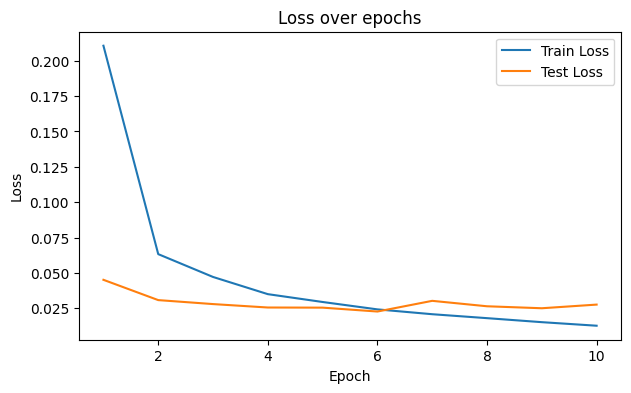

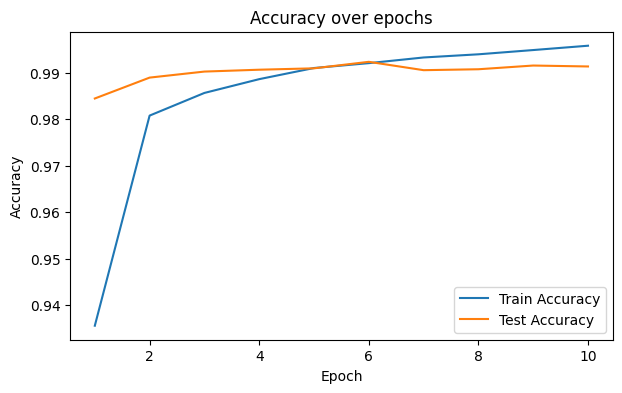

In [61]:
# --------------------------------------------------
# Plot training curves (loss and accuracy)
# --------------------------------------------------
# Visualizing training dynamics helps diagnose:
# - Underfitting   → low training and test accuracy
# - Overfitting    → training accuracy increases while test accuracy stalls or drops
# - Stable learning → both curves improve and converge

import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# ---- Loss curves ----
plt.figure(figsize=(7, 4))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()

# ---- Accuracy curves ----
plt.figure(figsize=(7, 4))
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()


In [62]:
# --------------------------------------------------
# Collect predictions and ground-truth labels
# --------------------------------------------------
# We run the trained model on the entire test set and store:
# - ground-truth labels
# - predicted labels
#
# These outputs are required for:
# - confusion matrix computation
# - misclassification analysis
# - detailed error inspection

model.eval()  # Ensure evaluation mode (dropout OFF)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Move batch to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        # Store results on CPU for analysis
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all batches into single tensors
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print("Total test samples:", len(all_labels))


Total test samples: 10000


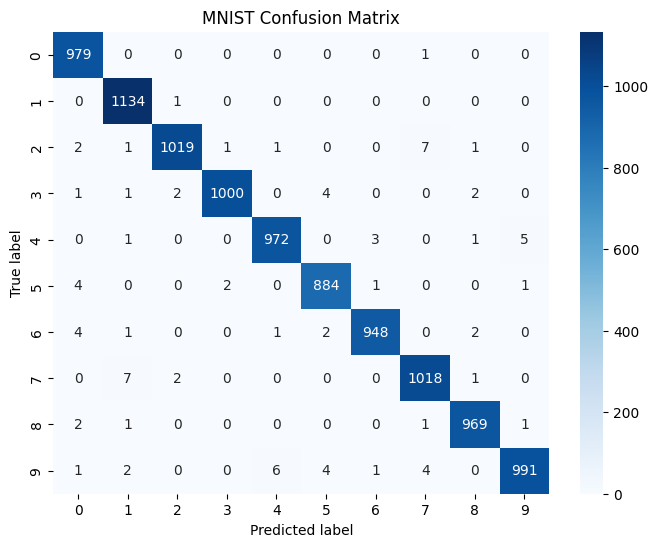

In [63]:
# --------------------------------------------------
# Confusion matrix
# --------------------------------------------------
# The confusion matrix provides a detailed view of model performance.
#
# Rows    → true labels
# Columns → predicted labels
#
# A perfect classifier would produce a purely diagonal matrix,
# indicating that all samples are classified correctly.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10)
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("MNIST Confusion Matrix")
plt.show()


In [64]:
# --------------------------------------------------
# Identify misclassified samples
# --------------------------------------------------
# We locate the indices where the model's prediction
# does not match the ground-truth label.
#
# These indices can be used for:
# - visual inspection of failure cases
# - error pattern analysis
# - qualitative discussion of model limitations

misclassified_idx = (all_preds != all_labels).nonzero(as_tuple=True)[0]

print("Number of misclassified samples:", len(misclassified_idx))


Number of misclassified samples: 86


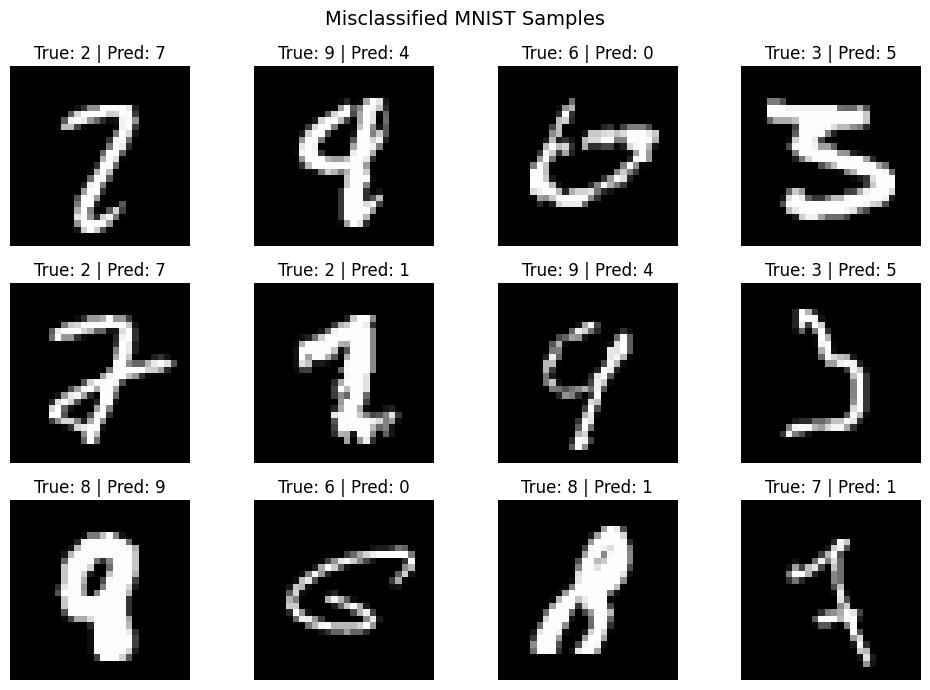

In [65]:
# --------------------------------------------------
# Visualize misclassified examples
# --------------------------------------------------
# This step is critical for developing real-world intuition.
# By inspecting misclassified samples, we can:
# - Understand which digit patterns confuse the model
# - Identify systematic errors (e.g., similar-looking digits)
# - Gain qualitative insight beyond aggregate metrics

NUM_SAMPLES = 12

fig, axes = plt.subplots(3, 4, figsize=(10, 7))
axes = axes.flatten()

for i in range(NUM_SAMPLES):
    idx = misclassified_idx[i].item()
    image, true_label = test_dataset[idx]
    pred_label = all_preds[idx].item()

    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"True: {true_label} | Pred: {pred_label}")
    axes[i].axis("off")

plt.suptitle("Misclassified MNIST Samples", fontsize=14)
plt.tight_layout()
plt.show()


#####################################################################


## Phase 2 — Real-World Dataset & Domain Shift Methodology

In this phase, we extend the MNIST baseline model to a more realistic setting by evaluating it on **real-world digit images**. The objective is to study how a model trained on a clean benchmark dataset behaves when exposed to data drawn from a different distribution, a phenomenon known as **domain shift**.

### Real-World Dataset Collection
A small custom dataset is constructed to simulate real deployment conditions. The dataset consists of:
- **Digitally drawn digits** (using basic drawing tools)
- **Photographed handwritten digits**, captured using a mobile camera

Each image contains a single digit (0–9) and is manually labeled using a filename-based convention. This design allows automated label extraction while maintaining traceability to the original samples.

### Motivation: Domain Shift
Unlike MNIST, real-world images exhibit variations such as:
- uneven lighting and shadows,
- different stroke thickness and writing styles,
- background noise,
- slight rotations and misalignments.

These differences result in a distribution mismatch between training data (MNIST) and deployment data (real-world images), often leading to degraded performance even for well-trained models.

### Preprocessing Strategy
To bridge the gap between real-world images and the MNIST data format, an OpenCV-based preprocessing pipeline is applied to all real-world samples. The preprocessing aims to:
- isolate the digit from the background,
- normalize contrast and reduce noise,
- preserve the digit’s aspect ratio,
- convert each image into a centered 28×28 grayscale representation consistent with MNIST.

All preprocessing outputs are visually inspected and saved to ensure correctness and transparency.

### Evaluation Protocol
The MNIST-trained CNN is evaluated on the preprocessed real-world dataset without any adaptation. Predictions, confidence scores, and failure cases are recorded. This evaluation establishes a **realistic baseline** and quantifies the impact of domain shift before applying any fine-tuning or adaptation techniques.

This phase sets the foundation for subsequent experiments focused on model adaptation and performance improvement under real-world conditions.


In [66]:
# --------------------------------------------------
# Phase 2 — Environment setup & imports
# --------------------------------------------------
# We install and import additional libraries required for:
# - real-world image preprocessing (OpenCV)
# - file handling and label parsing
# - result analysis and visualization

# Install OpenCV for image processing (only required in Colab)
!pip -q install opencv-python

# --------------------------------------------------
# Core Python & image processing libraries
# --------------------------------------------------
import os          # File and directory handling
import re          # Label extraction from filenames
import cv2         # OpenCV for image preprocessing
import numpy as np # Numerical operations

# --------------------------------------------------
# Analysis & visualization libraries
# --------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report


In [67]:
# --------------------------------------------------
# Mount Google Drive
# --------------------------------------------------

from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# --------------------------------------------------
# Real-world dataset paths
# --------------------------------------------------
# The dataset is organized as:
# real_world_digits/
# ├── paint/        → digitally drawn digits
# └── handwritten/ → photographed handwritten digits

ROOT_DIR = "/content/drive/MyDrive/real_world_digits"
PAINT_DIR = os.path.join(ROOT_DIR, "paint")
HAND_DIR  = os.path.join(ROOT_DIR, "handwritten")

# Sanity check: verify directories exist
print("PAINT_DIR exists:", os.path.isdir(PAINT_DIR), PAINT_DIR)
print("HAND_DIR exists :", os.path.isdir(HAND_DIR), HAND_DIR)


PAINT_DIR exists: True /content/drive/MyDrive/real_world_digits/paint
HAND_DIR exists : True /content/drive/MyDrive/real_world_digits/handwritten


In [69]:
# --------------------------------------------------
# Helper: list images from a folder
# --------------------------------------------------
# This utility function:
# - Scans a directory for image files
# - Filters by allowed extensions
# - Returns a sorted list of full file paths
#
# Sorting ensures a deterministic order, which is
# important for reproducibility and debugging.

IMG_EXTS = (".png", )

def list_images(folder):
    files = []
    for f in sorted(os.listdir(folder)):
        if f.lower().endswith(IMG_EXTS):
            files.append(os.path.join(folder, f))
    return files

# Collect image paths for each real-world source
paint_files = list_images(PAINT_DIR)
hand_files  = list_images(HAND_DIR)

# Display dataset contents for verification
print("Paint images:", len(paint_files))
for f in paint_files:
    print("  -", os.path.basename(f))

print("\nHandwritten images:", len(hand_files))
for f in hand_files:
    print("  -", os.path.basename(f))


Paint images: 10
  - 0_mnsit.png
  - 1_mnsit.png
  - 2_mnsit.png
  - 3_mnsit.png
  - 4_mnsit.png
  - 5_mnsit.png
  - 6_mnsit.png
  - 7_mnsit.png
  - 8_mnsit.png
  - 9_mnsit.png

Handwritten images: 10
  - hand_0.png
  - hand_1.png
  - hand_2.png
  - hand_3.png
  - hand_4.png
  - hand_5.png
  - hand_6.png
  - hand_7.png
  - hand_8.png
  - hand_9.png


In [70]:
# --------------------------------------------------
# Helper: extract label from filename
# --------------------------------------------------
# Real-world images are labeled using a filename convention
# (e.g., "3_mnist.png", "hand_7.png").
#
# This function:
# - Extracts digits (0–9) appearing in the filename
# - Uses the first detected digit as the class label
#
# This approach keeps labeling simple, reproducible,
# and avoids the need for a separate annotation file.

def label_from_filename(path):
    name = os.path.basename(path)
    nums = re.findall(r"\d", name)  # Find any digit characters in the filename

    if not nums:
        raise ValueError(f"Could not parse label from filename: {name}")

    return int(nums[0])  # Use the first digit found as the label

# Quick sanity check
if len(paint_files) > 0:
    print(os.path.basename(paint_files[0]), "->", label_from_filename(paint_files[0]))


0_mnsit.png -> 0


In [71]:
# --------------------------------------------------
# Preprocessing (v3): Real photo -> MNIST-like 28x28
# --------------------------------------------------
# Goal:
# Convert a real-world digit image (photo or drawing) into a MNIST-style input:
# - grayscale
# - digit is white on black
# - 28×28 pixels
# - centered and approximately the same scale as MNIST digits
#
# Key improvements vs other versions:
# - CLAHE + adaptive thresholding to handle uneven lighting (photos)
# - Contour filtering to avoid selecting paper borders, shadows, or noise
# - Select the most "digit-like" contour rather than blindly taking the largest one

def resize_keep_aspect(img, target=20):
    """
    Resize a binary digit image so its longer side becomes `target` pixels,
    while preserving aspect ratio (prevents distortion of digit shape).
    """
    h, w = img.shape[:2]
    if h > w:
        new_h = target
        new_w = int(round((w / h) * target))
    else:
        new_w = target
        new_h = int(round((h / w) * target))
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

def preprocess_to_mnist_28x28_v3(
    bgr_img,
    blur_ksize=5,
    use_clahe=True,
    threshold_mode="adaptive",   # "adaptive" works best for photos; "otsu" often works for clean drawings
    morph=True,
    debug=False
):
    # --------------------------------------------------
    # 1) Convert to grayscale (simplifies processing)
    # --------------------------------------------------
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)

    # --------------------------------------------------
    # 2) Contrast normalization (CLAHE)
    # --------------------------------------------------
    # This is especially useful for photos with shadows or uneven lighting,
    # making the digit strokes stand out more consistently.
    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

    # --------------------------------------------------
    # 3) Denoising / smoothing
    # --------------------------------------------------
    # A small Gaussian blur reduces sensor noise and paper texture,
    # making thresholding more stable.
    if blur_ksize and blur_ksize > 0:
        gray_blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    else:
        gray_blur = gray.copy()

    # --------------------------------------------------
    # 4) Binarization (digit -> white on black)
    # --------------------------------------------------
    # Adaptive thresholding handles non-uniform illumination better.
    if threshold_mode == "adaptive":
        th = cv2.adaptiveThreshold(
            gray_blur,
            255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV,  # invert: digit becomes white
            31,                     # neighborhood size (must be odd)
            10                      # constant subtracted (tunes sensitivity)
        )
    else:
        # Otsu is a good default for clean synthetic drawings
        _, th = cv2.threshold(gray_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # --------------------------------------------------
    # 5) Morphology (optional): remove specks + connect strokes
    # --------------------------------------------------
    # OPEN  -> removes small isolated noise
    # CLOSE -> connects broken strokes (important for thin handwriting)
    if morph:
        kernel = np.ones((3, 3), np.uint8)
        th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
        th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)

    # --------------------------------------------------
    # 6) Contour detection and filtering
    # --------------------------------------------------
    # Real photos often contain extra contours (paper edges, shadows, blobs).
    # We filter candidates using simple geometric heuristics.
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contours found. Try adjusting threshold parameters.")

    H, W = th.shape
    candidates = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)

        # Reject very small areas (likely noise)
        if area < 100:
            continue

        # Reject extremely large areas (likely background/paper region)
        if area > 0.5 * H * W:
            continue

        # Reject contours touching borders (often paper edges / shadows)
        border_margin = 5
        if (
            x <= border_margin or y <= border_margin or
            (x + w) >= (W - border_margin) or (y + h) >= (H - border_margin)
        ):
            continue

        # Reject extreme aspect ratios (e.g., long straight lines)
        aspect_ratio = w / float(h)
        if aspect_ratio < 0.2 or aspect_ratio > 5.0:
            continue

        candidates.append(cnt)

    if len(candidates) == 0:
        raise ValueError("No valid digit contour found. Image may be too messy or too faint.")

    # Choose the best remaining candidate (largest filtered contour)
    cnt = max(candidates, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    # Extra safety: ignore tiny detections
    if w < 8 or h < 8:
        raise ValueError("Detected contour too small. Likely noise.")

    # Region of interest: cropped digit
    roi = th[y:y+h, x:x+w]

    # --------------------------------------------------
    # 7) Resize digit to fit a ~20×20 box (MNIST-like scale)
    # --------------------------------------------------
    roi_resized = resize_keep_aspect(roi, target=20)

    # --------------------------------------------------
    # 8) Place resized digit onto a 28×28 canvas (centered)
    # --------------------------------------------------
    canvas = np.zeros((28, 28), dtype=np.uint8)
    h2, w2 = roi_resized.shape
    y_off = (28 - h2) // 2
    x_off = (28 - w2) // 2
    canvas[y_off:y_off+h2, x_off:x_off+w2] = roi_resized

    # --------------------------------------------------
    # 9) Center-of-mass alignment (reduces translation bias)
    # --------------------------------------------------
    # MNIST digits are usually centered. This step shifts the digit so its
    # mean pixel location is close to the center (14,14).
    ys, xs = np.where(canvas > 0)
    if len(xs) > 0 and len(ys) > 0:
        cx = int(np.round(xs.mean()))
        cy = int(np.round(ys.mean()))
        shift_x = 14 - cx
        shift_y = 14 - cy
        M = np.float32([[1, 0, shift_x],
                        [0, 1, shift_y]])
        canvas = cv2.warpAffine(canvas, M, (28, 28), borderValue=0)

    # --------------------------------------------------
    # Optional debug visualization
    # --------------------------------------------------
    if debug:
        plt.figure(figsize=(12, 3))
        plt.subplot(1, 4, 1); plt.title("Gray");       plt.imshow(gray, cmap="gray");      plt.axis("off")
        plt.subplot(1, 4, 2); plt.title("Blur");       plt.imshow(gray_blur, cmap="gray"); plt.axis("off")
        plt.subplot(1, 4, 3); plt.title("Binary");     plt.imshow(th, cmap="gray");        plt.axis("off")
        plt.subplot(1, 4, 4); plt.title("Final 28×28");plt.imshow(canvas, cmap="gray");    plt.axis("off")
        plt.show()

    return canvas


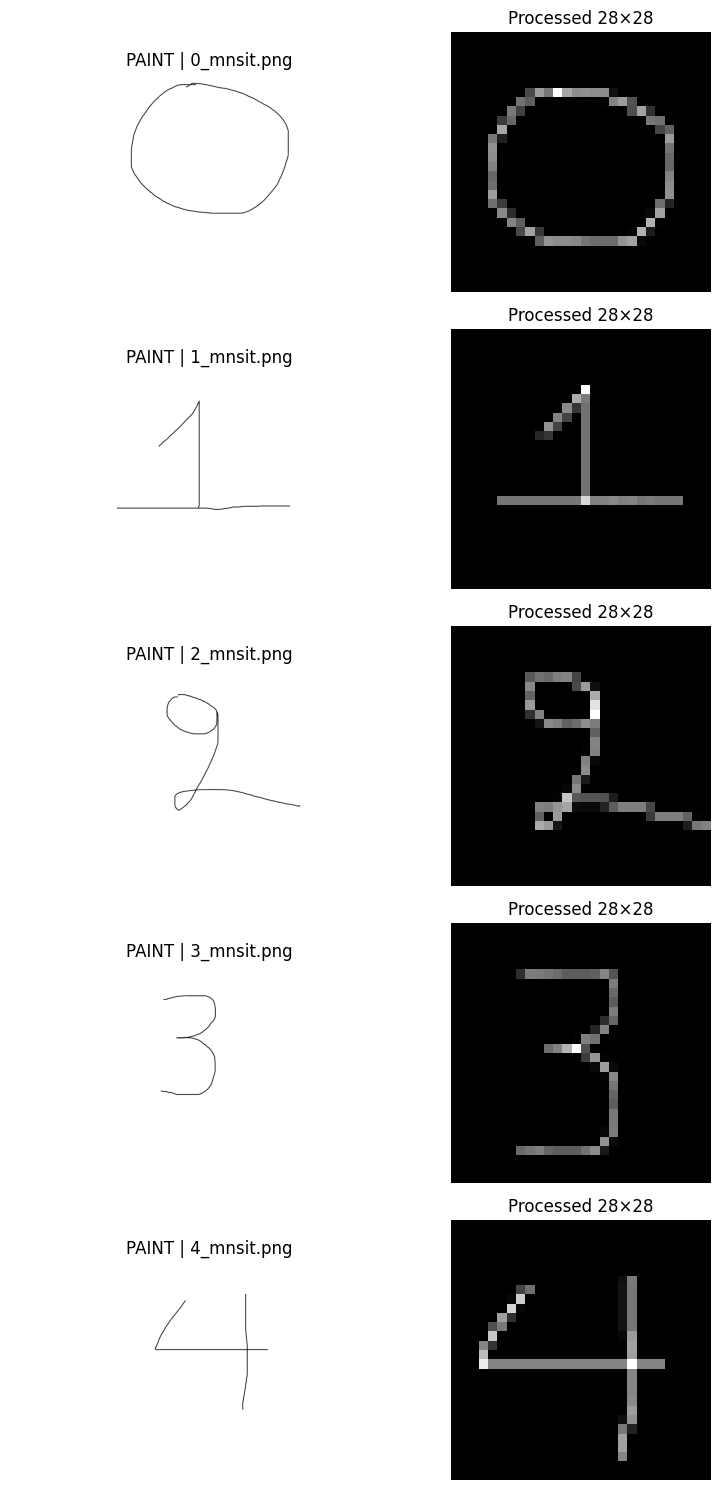

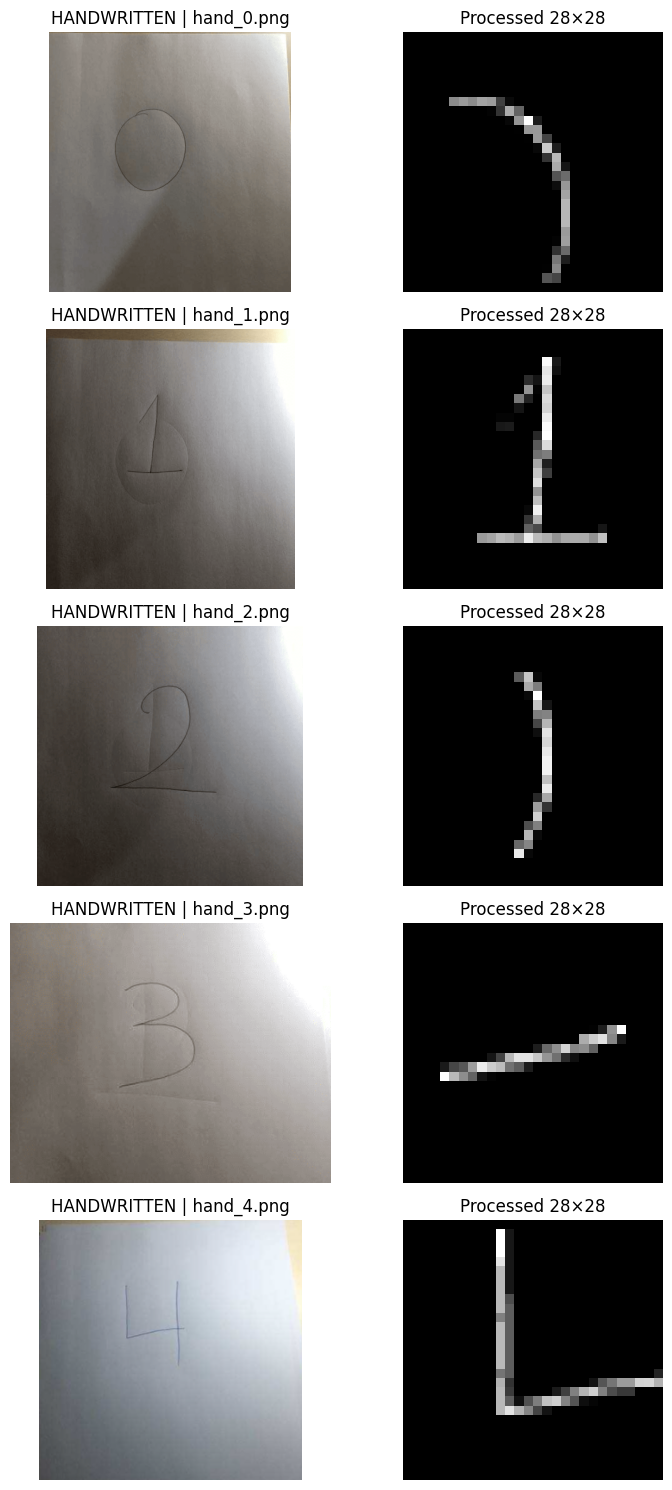

In [72]:
# --------------------------------------------------
# Sanity check: visualize preprocessing on multiple images
# --------------------------------------------------
# Before running batch evaluation, we validate that preprocessing produces
# reasonable MNIST-like 28×28 outputs.
#
# We display side-by-side:
# - Original image (RGB)
# - Preprocessed 28×28 binary digit (MNIST-like)
#
# We also handle failures gracefully:
# - unreadable files (cv2.imread returns None)
# - preprocessing errors (no valid contour, low contrast, etc.)

def test_preprocess_multiple(files, title, mode="adaptive", max_show=6):
    shown = 0
    plt.figure(figsize=(8, 3 * max_show))

    for path in files:
        if shown >= max_show:
            break

        # Read image from disk (BGR format in OpenCV)
        bgr = cv2.imread(path)
        if bgr is None:
            print(f"[WARNING] Could not read image: {path}")
            continue  # Skip unreadable files

        # Run preprocessing and catch common failures
        try:
            img28 = preprocess_to_mnist_28x28_v3(
                bgr,
                threshold_mode=mode,
                debug=False
            )
        except Exception as e:
            print(f"[WARNING] Preprocessing failed for {os.path.basename(path)}: {e}")
            continue

        # ---- Original image ----
        plt.subplot(max_show, 2, 2 * shown + 1)
        plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        plt.title(f"{title} | {os.path.basename(path)}")
        plt.axis("off")

        # ---- Preprocessed 28×28 image ----
        plt.subplot(max_show, 2, 2 * shown + 2)
        plt.imshow(img28, cmap="gray")
        plt.title("Processed 28×28")
        plt.axis("off")

        shown += 1

    if shown == 0:
        print("No valid images could be processed.")
    else:
        plt.tight_layout()
        plt.show()

# In practice:
# - Otsu often works well for clean, synthetic drawings (paint)
# - Adaptive thresholding is more robust for real photos (handwritten)
test_preprocess_multiple(paint_files, "PAINT", mode="otsu", max_show=5)
test_preprocess_multiple(hand_files, "HANDWRITTEN", mode="adaptive", max_show=5)


In [73]:
# --------------------------------------------------
# Preprocessing audit: run on ALL images and save previews
# --------------------------------------------------
# Why this step matters:
# - Preprocessing is the most failure-prone part of real-world ML pipelines.
# - Saving "original vs processed" previews makes the pipeline auditable.
# - We can quickly inspect whether digits are cropped/centered correctly,
#   and identify systematic preprocessing issues (e.g., shadows, borders).

def save_preprocess_results_all(
    files,
    title,
    out_dir,
    mode="adaptive"
):
    """
    For each image file:
    1) Load image safely (cv2.imread)
    2) Preprocess to MNIST-like 28×28 (safe: catch failures)
    3) Create a side-by-side preview (original vs processed)
    4) Save the preview PNG to disk for manual inspection

    This function is designed for transparency and debugging.
    """
    os.makedirs(out_dir, exist_ok=True)

    saved = 0
    failed_read = 0
    failed_prep = 0

    for path in files:
        fname = os.path.basename(path)

        # 1) Read image safely (OpenCV reads in BGR format)
        bgr = cv2.imread(path)
        if bgr is None:
            print(f"[READ FAIL] {fname}")
            failed_read += 1
            continue

        # 2) Preprocess safely (common failures: no contour, faint strokes, heavy shadows)
        try:
            img28 = preprocess_to_mnist_28x28_v3(
                bgr,
                threshold_mode=mode,
                debug=False
            )
        except Exception as e:
            print(f"[PREP FAIL] {fname} -> {e}")
            failed_prep += 1
            continue

        # 3) Plot original + processed (quick visual QA)
        plt.figure(figsize=(6, 3))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        plt.title(f"{title}\n{fname}")
        plt.axis("off")

        # Processed MNIST-like image (28×28)
        plt.subplot(1, 2, 2)
        plt.imshow(img28, cmap="gray")

        # If label parsing succeeds, show it in the title (helps spot label mistakes)
        try:
            lbl = label_from_filename(path)
            plt.title(f"Processed 28×28\nLabel={lbl}")
        except Exception:
            plt.title("Processed 28×28")

        plt.axis("off")
        plt.tight_layout()

        # 4) Save preview PNG
        save_path = os.path.join(out_dir, f"{os.path.splitext(fname)[0]}_preview.png")
        plt.savefig(save_path, dpi=150)
        plt.close()

        saved += 1
        print(f"[SAVED] {save_path}")

    # Summary report
    print("\n--- Summary ---")
    print("Saved:", saved)
    print("Read failed:", failed_read)
    print("Preprocess failed:", failed_prep)


In [74]:
# --------------------------------------------------
# Run preprocessing audit on PAINT images
# --------------------------------------------------
# Digit images drawn with digital tools (e.g., Paint) typically have:
# - clean backgrounds
# - high contrast
# - minimal lighting variation
#
# For this reason, Otsu thresholding often performs well and is used here.

OUT_PAINT = "/content/drive/MyDrive/real_world_digits/results_paint"

save_preprocess_results_all(
    paint_files,
    title="PAINT",
    out_dir=OUT_PAINT,
    mode="otsu"          # Otsu works well for clean, synthetic drawings
)


[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/0_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/1_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/2_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/3_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/4_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/5_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/6_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/7_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/8_mnsit_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_paint/9_mnsit_preview.png

--- Summary ---
Saved: 10
Read failed: 0
Preprocess failed: 0


In [75]:
# --------------------------------------------------
# Run preprocessing audit on HANDWRITTEN images
# --------------------------------------------------
# Handwritten digit images are typically captured with a camera and may include:
# - uneven lighting
# - shadows
# - paper texture
# - variable stroke thickness
#
# Adaptive thresholding is more robust under these conditions and is therefore
# used for handwritten images.

OUT_HAND = "/content/drive/MyDrive/real_world_digits/results_handwritten"

save_preprocess_results_all(
    hand_files,
    title="HANDWRITTEN",
    out_dir=OUT_HAND,
    mode="adaptive"      # adaptive thresholding handles real-world lighting better
)


[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_0_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_1_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_2_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_3_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_4_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_5_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_6_preview.png
[PREP FAIL] hand_7.png -> No valid digit contour found. Image may be too messy or too faint.
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_8_preview.png
[SAVED] /content/drive/MyDrive/real_world_digits/results_handwritten/hand_9_preview.png

--- Summary ---
Saved: 9
Read failed: 0
Preprocess failed: 1


In [76]:
# --------------------------------------------------
# Phase 2 — Batch inference on real-world images (robust)
# --------------------------------------------------
# We run the MNIST-trained CNN on our real-world dataset and store results in a DataFrame.
#
# Why this cell matters:
# - Establishes a "real-world baseline" before any fine-tuning/adaptation
# - Logs failures explicitly (read_fail / prep_fail) instead of crashing
# - Produces structured outputs suitable for:
#   - accuracy breakdowns (paint vs handwritten)
#   - confusion matrix / error analysis
#   - exporting results to CSV

import torch
import pandas as pd

# MNIST normalization constants (same as training)
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

def mnist_tensor_from_28x28(img_28):
    """
    Convert a preprocessed 28×28 image to a normalized tensor suitable for the CNN.

    Steps:
    - scale uint8 [0..255] -> float [0..1]
    - normalize with MNIST mean/std (must match training)
    - add batch and channel dimensions: (1, 1, 28, 28)
    """
    x = img_28.astype(np.float32) / 255.0
    x = (x - MNIST_MEAN) / MNIST_STD
    x = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)  # (B=1, C=1, H=28, W=28)
    return x

def predict_one_image(path, mode):
    """
    Run preprocessing + inference for a single image.

    Returns:
      pred   : predicted class (int) or None
      conf   : max softmax probability (float) or None
      status : "ok", "read_fail", or "prep_fail"
      err_msg: error string (empty if ok)
    """
    fname = os.path.basename(path)

    # 1) Read image safely
    bgr = cv2.imread(path)
    if bgr is None:
        return None, None, "read_fail", f"Could not read {fname}"

    # 2) Preprocess to MNIST-like 28×28
    try:
        img28 = preprocess_to_mnist_28x28_v3(bgr, threshold_mode=mode, debug=False)
    except Exception as e:
        return None, None, "prep_fail", str(e)

    # 3) Convert to model input tensor
    x = mnist_tensor_from_28x28(img28).to(device)

    # 4) Inference
    model.eval()
    with torch.no_grad():
        logits = model(x)

        # Convert logits -> probabilities for confidence reporting
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
        pred = int(np.argmax(probs))
        conf = float(np.max(probs))

    return pred, conf, "ok", ""

def run_batch(files, source, mode):
    """
    Run inference for a list of image files and return a list of result dicts.
    Each dict becomes one row in the final DataFrame.
    """
    rows = []
    for path in files:
        true_label = label_from_filename(path)
        pred, conf, status, err = predict_one_image(path, mode=mode)

        rows.append({
            "source": source,
            "filename": os.path.basename(path),
            "true": true_label,
            "pred": pred,
            "confidence": conf,
            "status": status,
            "error": err,
            "correct": int(pred == true_label) if status == "ok" else None
        })
    return rows

# Run batch inference for both sources (using the most suitable threshold mode per source)
rows = []
rows += run_batch(paint_files, "paint", mode="otsu")
rows += run_batch(hand_files, "handwritten", mode="adaptive")

# Results table (easy to filter, analyze, and export)
df = pd.DataFrame(rows)
df


,source,filename,true,pred,confidence,status,error,correct
0,paint,0_mnsit.png,0,0.0,0.150799,ok,,1.0
1,paint,1_mnsit.png,1,1.0,0.157926,ok,,1.0
2,paint,2_mnsit.png,2,1.0,0.156463,ok,,0.0
3,paint,3_mnsit.png,3,3.0,0.241933,ok,,1.0
4,paint,4_mnsit.png,4,4.0,0.183796,ok,,1.0
5,paint,5_mnsit.png,5,5.0,0.195455,ok,,1.0
6,paint,6_mnsit.png,6,6.0,0.207890,ok,,1.0
7,paint,7_mnsit.png,7,7.0,0.153904,ok,,1.0
8,paint,8_mnsit.png,8,7.0,0.132857,ok,,0.0
9,paint,9_mnsit.png,9,9.0,0.136918,ok,,1.0


In [77]:
# --------------------------------------------------
# Phase 2 — Metrics summary (exclude failed cases)
# --------------------------------------------------
# We separate two different failure modes:
# 1) Pipeline reliability: can we read + preprocess images successfully?
# 2) Model performance: given a valid 28×28 input, does the CNN classify correctly?
#
# For fair accuracy reporting, we compute accuracy ONLY on samples with status == "ok".

ok_df = df[df["status"] == "ok"].copy()

# ---- Pipeline reliability report ----
print("Total images:", len(df))
print("Processed OK:", len(ok_df))
print("Read failures:", (df["status"] == "read_fail").sum())
print("Preprocess failures:", (df["status"] == "prep_fail").sum())

# ---- Accuracy metrics (only valid samples) ----
print("\nAccuracy (only OK processed images):")
print("Overall:", round(ok_df["correct"].mean(), 4))

print("\nAccuracy by source:")
print(ok_df.groupby("source")["correct"].mean().round(4))

# ---- Confidence diagnostics ----
# Confidence is the max softmax probability. High confidence + wrong prediction
# is a strong indicator of domain shift or systematic preprocessing mismatch.
print("\nAverage confidence by source:")
print(ok_df.groupby("source")["confidence"].mean().round(4))

print("\nWorst confidence examples (OK only):")
display(
    ok_df.sort_values("confidence")
         .head(5)[["source", "filename", "true", "pred", "confidence", "correct"]]
)


Total images: 20
Processed OK: 19
Read failures: 0
Preprocess failures: 1

Accuracy (only OK processed images):
Overall: 0.5263

Accuracy by source:
source
handwritten    0.2222
paint          0.8000
Name: correct, dtype: float64

Average confidence by source:
source
handwritten    0.8317
paint          0.1718
Name: confidence, dtype: float64

Worst confidence examples (OK only):


,source,filename,true,pred,confidence,correct
8,paint,8_mnsit.png,8,7.0,0.132857,0.0
9,paint,9_mnsit.png,9,9.0,0.136918,1.0
0,paint,0_mnsit.png,0,0.0,0.150799,1.0
7,paint,7_mnsit.png,7,7.0,0.153904,1.0
2,paint,2_mnsit.png,2,1.0,0.156463,0.0


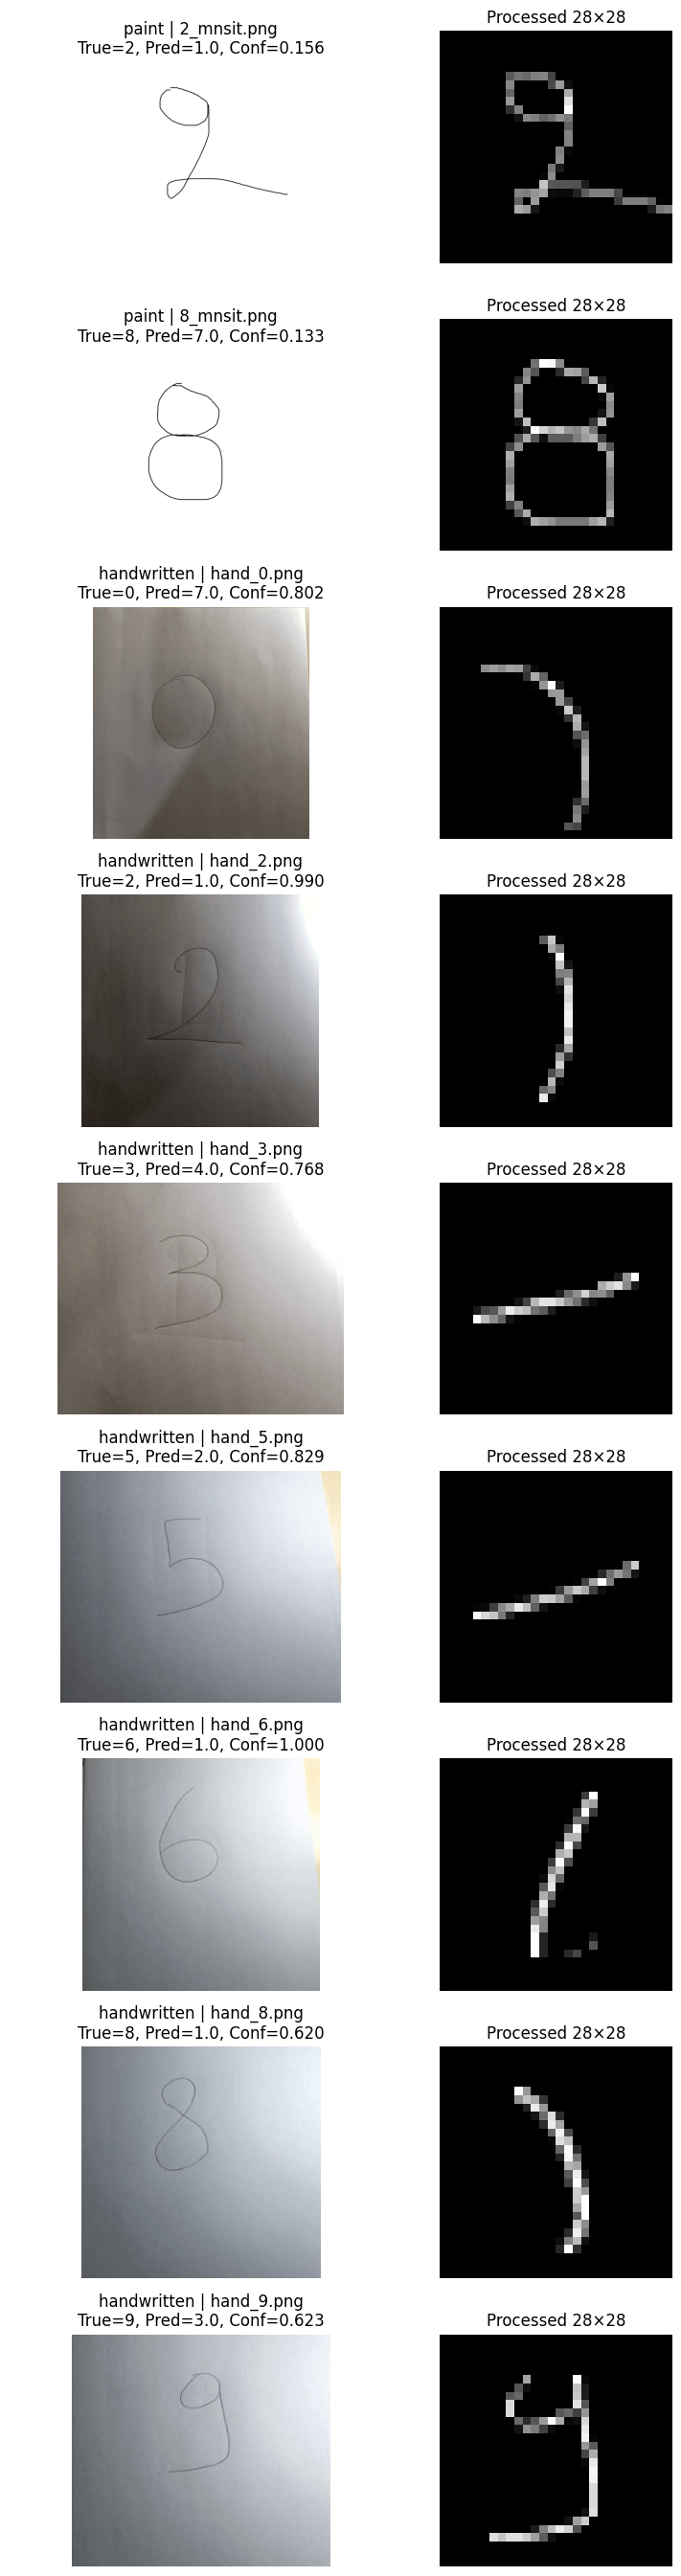

In [78]:
# --------------------------------------------------
# Phase 2 — Visualize mistakes (original + processed)
# --------------------------------------------------
# This is one of the most important steps in real-world ML debugging.
#
# We visualize misclassified samples side-by-side:
# - Original image (what a real user would provide)
# - Preprocessed 28×28 (what the model actually sees)
#
# This helps us determine whether errors come from:
# - preprocessing failures (bad cropping/thresholding/centering), or
# - true model limitations under domain shift.

def visualize_mistakes(df, max_show=10):
    # Focus only on valid preprocessing outputs and incorrect predictions
    mistakes = df[(df["status"] == "ok") & (df["correct"] == 0)].head(max_show)

    if len(mistakes) == 0:
        print("No mistakes to visualize (or none processed OK).")
        return

    n = len(mistakes)
    fig, axes = plt.subplots(n, 2, figsize=(8, 3 * n))

    # Ensure axes is always 2D (even when n == 1)
    if n == 1:
        axes = np.array([axes])

    for i, row in enumerate(mistakes.itertuples(index=False)):
        # Reconstruct the full file path and preprocessing mode
        # (paint -> otsu, handwritten -> adaptive)
        if row.source == "paint":
            path = os.path.join(PAINT_DIR, row.filename)
            mode = "otsu"
        else:
            path = os.path.join(HAND_DIR, row.filename)
            mode = "adaptive"

        # Load original image and regenerate the 28×28 processed version
        bgr = cv2.imread(path)
        img28 = preprocess_to_mnist_28x28_v3(bgr, threshold_mode=mode, debug=False)

        # ---- Original image ----
        axes[i, 0].imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(
            f"{row.source} | {row.filename}\n"
            f"True={row.true}, Pred={row.pred}, Conf={row.confidence:.3f}"
        )
        axes[i, 0].axis("off")

        # ---- Processed MNIST-like input ----
        axes[i, 1].imshow(img28, cmap="gray")
        axes[i, 1].set_title("Processed 28×28")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Show up to N incorrect examples for qualitative inspection
visualize_mistakes(df, max_show=10)


#####################################################################



# Phase 3 — Model Adaptation via Fine-Tuning

In Phase 2, we observed a significant performance drop when applying an MNIST-trained CNN to real-world digit images. This confirms the presence of **domain shift** between the MNIST training distribution and real deployment conditions (camera noise, lighting variation, stroke thickness, alignment).

This phase focuses on improving real-world performance using fine-tuning strategies.

---

## Mixed Fine-Tuning (MNIST + Real-World)

### Goal
- Improve accuracy on real-world images while **maintaining MNIST performance**
- Avoid overfitting to a very small real-world dataset (≈ 20 images)
- Introduce controlled augmentations to increase robustness

### Strategy
1. Build a **mixed training dataset**:
   - A subset of MNIST (e.g., 10k samples) with standard preprocessing
   - The real-world digit images with stronger (but safe) augmentations
2. Fine-tune the model using a **low learning rate** for a few epochs
3. Re-evaluate on the real-world dataset and compare results:
   **before → after → mixed**


In [79]:
# --------------------------------------------------
# Phase 3 — Build a real-world dataset (robust & safe)
# --------------------------------------------------
# We construct a small real-world dataset from your custom images.
#
# Key principles:
# - Reuse the SAME preprocessing pipeline used during evaluation
# - Normalize inputs exactly like MNIST (mean/std)
# - Explicitly track failures instead of silently ignoring them
# - Keep metadata (source, filename) for debugging and audits

import random
import torch
from torch.utils.data import Dataset, DataLoader

# MNIST normalization constants (must match training)
MNIST_MEAN = 0.1307
MNIST_STD  = 0.3081

def to_mnist_normalized_tensor(img28_uint8):
    """
    Convert a preprocessed MNIST-like image to a normalized tensor.

    Input:
      img28_uint8 : (28, 28) uint8 array, digit white on black

    Output:
      torch.FloatTensor of shape (1, 28, 28), normalized like MNIST
    """
    x = img28_uint8.astype(np.float32) / 255.0
    x = (x - MNIST_MEAN) / MNIST_STD
    return torch.from_numpy(x).unsqueeze(0)  # (C=1, H=28, W=28)

def load_and_preprocess(path, mode):
    """
    Safely load and preprocess a real-world image.

    Returns:
      img28 : preprocessed 28×28 image or None
      status: "ok", "read_fail", or "prep_fail"
    """
    bgr = cv2.imread(path)
    if bgr is None:
        return None, "read_fail"

    try:
        img28 = preprocess_to_mnist_28x28_v3(
            bgr,
            threshold_mode=mode,
            debug=False
        )
        return img28, "ok"
    except Exception:
        return None, "prep_fail"

# --------------------------------------------------
# Collect usable samples (skip failures)
# --------------------------------------------------
# We explicitly record failures to understand pipeline robustness.

samples = []
failures = []

# Process PAINT images (clean, synthetic → Otsu)
for p in paint_files:
    img28, status = load_and_preprocess(p, mode="otsu")
    if status == "ok":
        samples.append(
            (img28, label_from_filename(p), "paint", os.path.basename(p))
        )
    else:
        failures.append((os.path.basename(p), "paint", status))

# Process HANDWRITTEN images (photos → adaptive threshold)
for p in hand_files:
    img28, status = load_and_preprocess(p, mode="adaptive")
    if status == "ok":
        samples.append(
            (img28, label_from_filename(p), "handwritten", os.path.basename(p))
        )
    else:
        failures.append((os.path.basename(p), "handwritten", status))

# --------------------------------------------------
# Dataset summary
# --------------------------------------------------
print("Total usable samples:", len(samples))
print("Failures:", len(failures))

if failures:
    print("Failure list:")
    for f in failures:
        print(" ", f)


Total usable samples: 19
Failures: 1
Failure list:
  ('hand_7.png', 'handwritten', 'prep_fail')


In [80]:
# --------------------------------------------------
# Phase 3 — Lightweight data augmentation for 28×28 digits
# --------------------------------------------------
# Purpose:
# - Increase effective dataset size without collecting new images
# - Improve robustness to small variations seen in real-world input
# - Avoid aggressive transformations that would distort digit identity
#
# Important:
# - All augmentations operate in 28×28 space
# - The output remains MNIST-compatible (white digit on black background)

def augment_28x28(img28):
    """
    Apply lightweight, MNIST-safe augmentations.

    Input:
      img28 : uint8 array of shape (28, 28),
              digit in white on black background

    Output:
      Augmented uint8 image of shape (28, 28)
    """
    img = img28.copy()

    # --------------------------------------------------
    # 1) Small rotation + translation
    # --------------------------------------------------
    # Simulates natural variations in writing angle and camera alignment.
    # Ranges are intentionally small to preserve digit semantics.
    angle = random.uniform(-15, 15)   # degrees
    tx = random.uniform(-2, 2)         # horizontal shift (pixels)
    ty = random.uniform(-2, 2)         # vertical shift (pixels)

    M = cv2.getRotationMatrix2D((14, 14), angle, 1.0)
    M[0, 2] += tx
    M[1, 2] += ty
    img = cv2.warpAffine(img, M, (28, 28), borderValue=0)

    # --------------------------------------------------
    # 2) Optional dilation (thin strokes)
    # --------------------------------------------------
    # Helps handwritten digits with very thin strokes resemble MNIST
    # thickness distribution.
    if random.random() < 0.3:
        kernel = np.ones((2, 2), np.uint8)
        img = cv2.dilate(img, kernel, iterations=1)

    # --------------------------------------------------
    # 3) Optional mild Gaussian noise
    # --------------------------------------------------
    # Simulates sensor noise and minor background artifacts.
    # Kept intentionally small to avoid destroying digit structure.
    if random.random() < 0.3:
        noise = np.random.normal(0, 5, img.shape).astype(np.float32)
        img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    return img


In [81]:
# --------------------------------------------------
# Phase 3 — Real-world Dataset class + train/val split
# --------------------------------------------------
# We wrap the preprocessed real-world samples into a PyTorch Dataset so we can:
# - apply augmentations "on the fly" during training
# - load batches using a DataLoader
# - keep metadata (source, filename) for debugging / error analysis
#
# We also create a small train/validation split (80/20) to:
# - monitor overfitting (very important with ~20 samples)
# - tune learning rate / epochs safely

class RealWorldDigitsDataset(Dataset):
    def __init__(self, samples, augment=False):
        """
        samples: list of tuples -> (img28_uint8, label, source, filename)
        augment: if True, apply lightweight augmentations during __getitem__
        """
        self.samples = samples
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img28, label, source, fname = self.samples[idx]

        # Apply augmentations only during training
        if self.augment:
            img28 = augment_28x28(img28)

        # Convert to MNIST-normalized tensor
        x = to_mnist_normalized_tensor(img28)   # (1, 28, 28)
        y = torch.tensor(label, dtype=torch.long)

        # Returning metadata helps later debugging (which file failed and why)
        return x, y, source, fname

# --------------------------------------------------
# Train/Validation split (80/20)
# --------------------------------------------------
# With very small datasets, validation can be tiny.
# We ensure at least 1 training sample using max(1, ...).

random.shuffle(samples)
split = max(1, int(0.8 * len(samples)))

train_samples = samples[:split]
val_samples   = samples[split:]

print("Train:", len(train_samples), "Val:", len(val_samples))

# Training dataset uses augmentation; validation does not
train_ds = RealWorldDigitsDataset(train_samples, augment=True)
val_ds   = RealWorldDigitsDataset(val_samples, augment=False)

# Small batch size is appropriate for tiny datasets
train_loader_rw = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader_rw   = DataLoader(val_ds, batch_size=8, shuffle=False)


Train: 15 Val: 4


In [82]:
# --------------------------------------------------
# Phase 3 — Fine-tuning setup (freeze feature extractor)
# --------------------------------------------------
# With a very small real-world dataset, full fine-tuning would almost
# certainly lead to overfitting.
#
# Strategy:
# - Freeze all convolutional layers (feature extractor)
# - Fine-tune only the classifier head (Linear layers)
#
# This allows the model to:
# - Keep robust MNIST-learned visual features (edges, strokes)
# - Adapt decision boundaries to the real-world domain

import torch.nn as nn

# --------------------------------------------------
# Freeze all model parameters
# --------------------------------------------------
for p in model.parameters():
    p.requires_grad = False

# --------------------------------------------------
# Unfreeze classifier head only
# --------------------------------------------------
# We automatically unfreeze all nn.Linear layers.
# This makes the code robust even if the model architecture changes.
for m in model.modules():
    if isinstance(m, nn.Linear):
        for p in m.parameters():
            p.requires_grad = True

# --------------------------------------------------
# Optimizer & loss (only trainable parameters)
# --------------------------------------------------
# Low learning rate is critical for stable fine-tuning.
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer_ft = torch.optim.Adam(
    trainable_params,
    lr=1e-4        # small LR to avoid destroying learned representations
)

criterion = nn.CrossEntropyLoss()

print("Trainable parameters:", sum(p.numel() for p in trainable_params))


Trainable parameters: 402826


In [83]:
# --------------------------------------------------
# Phase 3 — Fine-tune on real-world samples (small-data setup)
# --------------------------------------------------
# We fine-tune only the classifier head (Linear layers) using:
# - a small learning rate
# - lightweight augmentations (train only)
# - a validation split to monitor overfitting
#
# Note:
# The real-world dataloader returns (x, y, source, filename).
# We ignore source/filename here, but keep them available for debugging later.

def eval_loader(loader):
    """
    Evaluate loss and accuracy on a given loader.
    We use:
    - model.eval() to disable dropout
    - torch.no_grad() for speed and reduced memory
    """
    model.eval()

    total, correct = 0, 0
    losses = []

    with torch.no_grad():
        for x, y, _, _ in loader:
            x, y = x.to(device), y.to(device)

            logits = model(x)
            loss = criterion(logits, y)
            losses.append(loss.item())

            pred = logits.argmax(dim=1)
            total += y.size(0)
            correct += (pred == y).sum().item()

    return float(np.mean(losses)), correct / max(1, total)

EPOCHS_FT = 10
model.to(device)

for epoch in range(1, EPOCHS_FT + 1):
    # --------------------------------------------------
    # Training (one epoch)
    # --------------------------------------------------
    model.train()  # enable training mode

    train_losses = []
    train_total, train_correct = 0, 0

    for x, y, _, _ in train_loader_rw:
        x, y = x.to(device), y.to(device)

        # Forward + loss
        optimizer_ft.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)

        # Backprop + update (only trainable params are updated)
        loss.backward()
        optimizer_ft.step()

        # Track training metrics
        train_losses.append(loss.item())
        pred = logits.argmax(dim=1)
        train_total += y.size(0)
        train_correct += (pred == y).sum().item()

    train_loss = float(np.mean(train_losses))
    train_acc = train_correct / max(1, train_total)

    # --------------------------------------------------
    # Validation (no gradients)
    # --------------------------------------------------
    val_loss, val_acc = eval_loader(val_loader_rw)

    # Epoch summary
    print(
        f"FT Epoch {epoch:02d}/{EPOCHS_FT} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


FT Epoch 01/10 | Train Loss: 4.3732, Train Acc: 0.1333 | Val Loss: 1.9044, Val Acc: 0.7500
FT Epoch 02/10 | Train Loss: 4.1667, Train Acc: 0.2667 | Val Loss: 1.9046, Val Acc: 0.7500
FT Epoch 03/10 | Train Loss: 5.1418, Train Acc: 0.2667 | Val Loss: 1.9052, Val Acc: 0.7500
FT Epoch 04/10 | Train Loss: 4.3309, Train Acc: 0.4000 | Val Loss: 1.9055, Val Acc: 0.7500
FT Epoch 05/10 | Train Loss: 3.1434, Train Acc: 0.4000 | Val Loss: 1.9058, Val Acc: 0.7500
FT Epoch 06/10 | Train Loss: 3.8717, Train Acc: 0.2667 | Val Loss: 1.9059, Val Acc: 0.7500
FT Epoch 07/10 | Train Loss: 2.7666, Train Acc: 0.4000 | Val Loss: 1.9060, Val Acc: 0.7500
FT Epoch 08/10 | Train Loss: 2.6724, Train Acc: 0.4000 | Val Loss: 1.9058, Val Acc: 0.7500
FT Epoch 09/10 | Train Loss: 3.2365, Train Acc: 0.2667 | Val Loss: 1.9056, Val Acc: 0.7500
FT Epoch 10/10 | Train Loss: 3.0443, Train Acc: 0.2667 | Val Loss: 1.9055, Val Acc: 0.7500


In [84]:
# --------------------------------------------------
# Phase 3 — Final evaluation on real-world dataset
# --------------------------------------------------
# After fine-tuning, we re-evaluate the model on the full set of usable
# real-world samples.
#
# Important:
# - We use the SAME preprocessed images as before
# - No augmentations are applied during evaluation
# - This allows a fair comparison:
#     baseline (MNIST only) → fine-tuned model

def predict_dataset(samples_list):
    """
    Run inference on a list of real-world samples.

    Input:
      samples_list: list of tuples
        (img28_uint8, label, source, filename)

    Output:
      pandas DataFrame with:
        - true label
        - predicted label
        - confidence (max softmax probability)
        - correctness flag
    """
    model.eval()
    rows = []

    with torch.no_grad():
        for img28, label, source, fname in samples_list:
            # Convert to MNIST-normalized tensor
            x = to_mnist_normalized_tensor(img28).unsqueeze(0).to(device)  # (1, 1, 28, 28)

            logits = model(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()

            pred = int(np.argmax(probs))
            conf = float(np.max(probs))

            rows.append({
                "source": source,
                "filename": fname,
                "true": int(label),
                "pred": pred,
                "confidence": conf,
                "correct": int(pred == label)
            })

    return pd.DataFrame(rows)

# Run evaluation on the full real-world dataset
df_after = predict_dataset(samples)

print("Overall accuracy:", df_after["correct"].mean())
print("\nAccuracy by source:")
print(df_after.groupby("source")["correct"].mean())

df_after


Overall accuracy: 0.5789473684210527

Accuracy by source:
source
handwritten    0.222222
paint          0.900000
Name: correct, dtype: float64


,source,filename,true,pred,confidence,correct
0,handwritten,hand_4.png,4,4,0.928657,1
1,handwritten,hand_3.png,3,4,0.759311,0
2,paint,4_mnsit.png,4,4,0.184611,1
3,paint,9_mnsit.png,9,9,0.140067,1
4,paint,5_mnsit.png,5,5,0.199817,1
5,handwritten,hand_5.png,5,2,0.804863,0
6,handwritten,hand_8.png,8,1,0.559126,0
7,paint,6_mnsit.png,6,6,0.219825,1
8,handwritten,hand_2.png,2,1,0.985257,0
9,handwritten,hand_6.png,6,1,0.998669,0


In [85]:
# --------------------------------------------------
# Phase 3 — Create MNIST subset loader (for mixed fine-tuning)
# --------------------------------------------------
# We use a SUBSET of MNIST rather than the full dataset to:
# - keep training fast
# - reduce dominance of MNIST over the tiny real-world dataset
# - still retain the general digit structure learned from MNIST
#
# This subset will later be mixed with real-world samples
# during fine-tuning.

from torch.utils.data import DataLoader, Subset
import numpy as np
import random

# --------------------------------------------------
# Reproducibility
# --------------------------------------------------
# Fixing seeds ensures the same MNIST subset is selected
# across runs, making experiments comparable.
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# --------------------------------------------------
# Build MNIST subset
# --------------------------------------------------
# 10,000 samples is a good trade-off:
# - large enough to preserve MNIST performance
# - small enough to avoid overwhelming real-world samples
MNIST_SUBSET_SIZE = 10_000

# Randomly select subset indices
mnist_indices = np.random.permutation(len(train_dataset))[:MNIST_SUBSET_SIZE]
mnist_subset = Subset(train_dataset, mnist_indices)

# DataLoader for MNIST subset
mnist_loader = DataLoader(
    mnist_subset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("MNIST subset size:", len(mnist_subset))


MNIST subset size: 10000


In [86]:
# --------------------------------------------------
# Phase 3 — Real-world DataLoader (for mixed fine-tuning)
# --------------------------------------------------
# This dataset wraps the preprocessed real-world samples so they can:
# - be augmented on the fly
# - be loaded in mini-batches
# - be mixed with MNIST batches during training
#

from torch.utils.data import Dataset, DataLoader

class RealWorldDigitsDataset(Dataset):
    def __init__(self, samples, augment=False):
        """
        samples : list of tuples
                  (img28_uint8, label, source, filename)
        augment : if True, apply lightweight augmentations during training
        """
        self.samples = samples
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img28, label, source, fname = self.samples[idx]

        # Apply augmentation only during training
        if self.augment:
            img28 = augment_28x28(img28)

        # Convert to MNIST-normalized tensor
        x = to_mnist_normalized_tensor(img28)   # (1, 28, 28)
        y = torch.tensor(label, dtype=torch.long)

        # Metadata (source, filename) kept for debugging if needed
        return x, y, source, fname

# --------------------------------------------------
# Real-world DataLoader
# --------------------------------------------------
# Small batch size is intentional due to the very limited dataset size.
# These batches will be mixed with MNIST batches during training.

real_train_ds = RealWorldDigitsDataset(samples, augment=True)
real_loader = DataLoader(real_train_ds, batch_size=8, shuffle=True)

print("Real-world usable samples:", len(real_train_ds))


Real-world usable samples: 19


In [87]:
# --------------------------------------------------
# Phase 3 — Mixed fine-tuning (precise MNIST/Real ratio control)
# --------------------------------------------------
# Goal:
# Control the exposure ratio explicitly, e.g.:
# - 70% MNIST batches (retain general digit structure)
# - 30% Real-world batches (adapt to your domain)
#
# Why this is better than alternating:
# - Alternating gives only ~50/50 (unless you hack steps)
# - This approach gives a stable, intentional mixture every epoch
#
# Approach:
# - Unfreeze all layers (for better adaptation)
# - Very low LR for stability
# - At each step, sample which dataset to draw a batch from
#   using a Bernoulli(p_real) decision

import torch.nn as nn
import numpy as np

criterion = nn.CrossEntropyLoss()

# --------------------------------------------------
# Fine-tuning settings
# --------------------------------------------------
for p in model.parameters():
    p.requires_grad = True

optimizer_mixed = torch.optim.Adam(model.parameters(), lr=5e-5)

EPOCHS_MIXED = 5
model.to(device)

# --------------------------------------------------
# Precise ratio configuration
# --------------------------------------------------
P_REAL = 0.30           # 30% real-world, 70% MNIST
STEPS_PER_EPOCH = 300   # how many total update steps per epoch (tune as you like)

# Note:
# - If you set STEPS_PER_EPOCH too large, you'll see the same real images many times.
# - That's okay as long as augmentations are on, and LR is low.

def get_next_batch(it, loader, is_real=False):
    """
    Fetch next batch from an iterator; restart iterator if exhausted.

    Returns:
      x, y, it (possibly restarted)
    """
    try:
        batch = next(it)
    except StopIteration:
        it = iter(loader)
        batch = next(it)

    if is_real:
        x, y, _, _ = batch  # real loader returns metadata too
    else:
        x, y = batch        # mnist loader returns just (x, y)

    return x, y, it

def eval_real_world(samples_list):
    model.eval()
    rows = []
    with torch.no_grad():
        for img28, label, source, fname in samples_list:
            x = to_mnist_normalized_tensor(img28).unsqueeze(0).to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
            pred = int(np.argmax(probs))
            conf = float(np.max(probs))
            rows.append({
                "source": source,
                "filename": fname,
                "true": int(label),
                "pred": pred,
                "confidence": conf,
                "correct": int(pred == label)
            })
    df_eval = pd.DataFrame(rows)
    overall = df_eval["correct"].mean()
    by_src = df_eval.groupby("source")["correct"].mean()
    return df_eval, overall, by_src

# --------------------------------------------------
# Training loop
# --------------------------------------------------
for epoch in range(1, EPOCHS_MIXED + 1):
    model.train()

    mnist_iter = iter(mnist_loader)
    real_iter  = iter(real_loader)

    train_losses = []

    # For reporting the achieved ratio (sanity check)
    used_mnist = 0
    used_real  = 0

    for step in range(STEPS_PER_EPOCH):
        # Sample dataset source with precise probability
        use_real = (np.random.rand() < P_REAL)

        if use_real:
            x, y, real_iter = get_next_batch(real_iter, real_loader, is_real=True)
            used_real += 1
        else:
            x, y, mnist_iter = get_next_batch(mnist_iter, mnist_loader, is_real=False)
            used_mnist += 1

        x, y = x.to(device), y.to(device)

        optimizer_mixed.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer_mixed.step()

        train_losses.append(loss.item())

    # Evaluate on real-world after each epoch
    df_eval, overall_acc, by_src_acc = eval_real_world(samples)

    # Sanity: report actual ratio used in this epoch
    total_steps = used_mnist + used_real
    real_ratio = used_real / max(1, total_steps)

    print(
        f"Mixed Epoch {epoch}/{EPOCHS_MIXED} | "
        f"Train Loss: {np.mean(train_losses):.4f} | "
        f"Real Overall Acc: {overall_acc:.4f} | "
        f"Real Batch Ratio: {real_ratio:.2f} (target {P_REAL:.2f})"
    )
    print("Real Acc by source:")
    print(by_src_acc.round(4))


Mixed Epoch 1/5 | Train Loss: 0.7458 | Real Overall Acc: 0.5789 | Real Batch Ratio: 0.30 (target 0.30)
Real Acc by source:
source
handwritten    0.3333
paint          0.8000
Name: correct, dtype: float64
Mixed Epoch 2/5 | Train Loss: 0.5662 | Real Overall Acc: 0.7368 | Real Batch Ratio: 0.28 (target 0.30)
Real Acc by source:
source
handwritten    0.5556
paint          0.9000
Name: correct, dtype: float64
Mixed Epoch 3/5 | Train Loss: 0.4706 | Real Overall Acc: 0.8947 | Real Batch Ratio: 0.29 (target 0.30)
Real Acc by source:
source
handwritten    0.8889
paint          0.9000
Name: correct, dtype: float64
Mixed Epoch 4/5 | Train Loss: 0.4164 | Real Overall Acc: 0.8421 | Real Batch Ratio: 0.33 (target 0.30)
Real Acc by source:
source
handwritten    0.8889
paint          0.8000
Name: correct, dtype: float64
Mixed Epoch 5/5 | Train Loss: 0.3182 | Real Overall Acc: 0.8947 | Real Batch Ratio: 0.28 (target 0.30)
Real Acc by source:
source
handwritten    0.8889
paint          0.9000
Name: corr

In [88]:
# --------------------------------------------------
# Phase 3 — Final real-world report (after mixed fine-tuning)
# --------------------------------------------------
# Purpose:
# Summarize how the model performs on the full real-world dataset after
# mixed fine-tuning (MNIST + real-world).
#
# We report:
# - overall accuracy
# - accuracy split by source (paint vs handwritten)
# - the most suspicious errors (wrong + low confidence first)

df_mixed, overall_mixed, by_src_mixed = eval_real_world(samples)

print("FINAL (Mixed Fine-tuning) — Real-world accuracy")
print("Overall:", round(overall_mixed, 4))

print("\nBy source:")
print(by_src_mixed.round(4))

# --------------------------------------------------
# Error inspection table
# --------------------------------------------------
# We recompute correctness explicitly (safe even if eval_real_world changes later)
# Then we sort so the top rows show:
# - incorrect predictions first
# - among them, the lowest-confidence predictions first
#   (these often indicate weak preprocessing / unclear digits)
df_mixed["correct"] = (df_mixed["pred"] == df_mixed["true"]).astype(int)

display(
    df_mixed.sort_values(["correct", "confidence"], ascending=[True, True])
            .head(10)
)


FINAL (Mixed Fine-tuning) — Real-world accuracy
Overall: 0.8947

By source:
source
handwritten    0.8889
paint          0.9000
Name: correct, dtype: float64


,source,filename,true,pred,confidence,correct
16,paint,8_mnsit.png,8,5,0.257337,0
1,handwritten,hand_3.png,3,5,0.662122,0
11,paint,1_mnsit.png,1,1,0.251314,1
15,paint,7_mnsit.png,7,7,0.398746,1
3,paint,9_mnsit.png,9,9,0.572227,1
2,paint,4_mnsit.png,4,4,0.586494,1
17,paint,0_mnsit.png,0,0,0.601978,1
13,paint,2_mnsit.png,2,2,0.615155,1
4,paint,5_mnsit.png,5,5,0.729128,1
10,handwritten,hand_0.png,0,0,0.764300,1


In [89]:
# --------------------------------------------------
# Phase 3 — Export results (before vs after vs mixed)
# --------------------------------------------------
# We export evaluation results from all stages to CSV so they can be:
# - inspected outside Colab
# - plotted later (Excel / Python / R)
# - attached to reports or a GitHub repository
#
# Expected DataFrames in memory:
# - df        : BEFORE fine-tuning (MNIST-only model)
# - df_after  : AFTER real-world-only fine-tuning
# - df_mixed  : AFTER mixed fine-tuning (MNIST + real-world)
#
# Each DataFrame should include at least:
# ["source", "filename", "true", "pred", "confidence", "correct"]
#
# Additional columns (e.g. "status", "error") are preserved if present.

import os
import pandas as pd

def export_stage_csv(df_stage, stage_name, out_dir):
    """
    Export a single evaluation stage to CSV.

    Parameters:
      df_stage   : pandas DataFrame with evaluation results
      stage_name : string identifier ("before", "after", "mixed")
      out_dir    : output directory

    Returns:
      Full path to the saved CSV file
    """
    os.makedirs(out_dir, exist_ok=True)

    # Preferred column order (only keep columns that exist)
    preferred_cols = [
        "stage",
        "source",
        "filename",
        "true",
        "pred",
        "confidence",
        "correct",
        "status",
        "error"
    ]

    df_out = df_stage.copy()
    df_out.insert(0, "stage", stage_name)

    cols = [c for c in preferred_cols if c in df_out.columns]
    df_out = df_out[cols]

    save_path = os.path.join(out_dir, f"results_{stage_name}.csv")
    df_out.to_csv(save_path, index=False)

    print(f"[SAVED] {save_path} | rows={len(df_out)}")
    return save_path

def export_all_stages_to_csv(out_dir, df_before=None, df_after=None, df_mixed=None):
    """
    Export all available stages and also create a combined CSV.

    Returns:
      Dictionary with paths to all generated CSV files.
    """
    paths = {}
    combined = []

    if df_before is not None:
        paths["before"] = export_stage_csv(df_before, "before", out_dir)
        combined.append(pd.read_csv(paths["before"]))

    if df_after is not None:
        paths["after"] = export_stage_csv(df_after, "after", out_dir)
        combined.append(pd.read_csv(paths["after"]))

    if df_mixed is not None:
        paths["mixed"] = export_stage_csv(df_mixed, "mixed", out_dir)
        combined.append(pd.read_csv(paths["mixed"]))

    # Create a unified CSV for cross-stage comparison
    if combined:
        df_all = pd.concat(combined, ignore_index=True)
        all_path = os.path.join(out_dir, "results_all_stages.csv")
        df_all.to_csv(all_path, index=False)

        paths["all"] = all_path
        print(f"[SAVED] {all_path} | rows={len(df_all)}")

    return paths

# --------------------------------------------------
# Run export
# --------------------------------------------------
OUT_CSV_DIR = "/content/drive/MyDrive/real_world_digits/exports"

paths = export_all_stages_to_csv(
    OUT_CSV_DIR,
    df_before=df,       # MNIST-only baseline
    df_after=df_after,  # real-world-only fine-tuning
    df_mixed=df_mixed   # mixed fine-tuning
)

paths


[SAVED] /content/drive/MyDrive/real_world_digits/exports/results_before.csv | rows=20
[SAVED] /content/drive/MyDrive/real_world_digits/exports/results_after.csv | rows=19
[SAVED] /content/drive/MyDrive/real_world_digits/exports/results_mixed.csv | rows=19
[SAVED] /content/drive/MyDrive/real_world_digits/exports/results_all_stages.csv | rows=58


{'before': '/content/drive/MyDrive/real_world_digits/exports/results_before.csv',
 'after': '/content/drive/MyDrive/real_world_digits/exports/results_after.csv',
 'mixed': '/content/drive/MyDrive/real_world_digits/exports/results_mixed.csv',
 'all': '/content/drive/MyDrive/real_world_digits/exports/results_all_stages.csv'}

,stage,n,overall,paint,handwritten
0,before,19,0.526316,0.8,0.222222
1,after,19,0.578947,0.9,0.222222
2,mixed,19,0.894737,0.9,0.888889


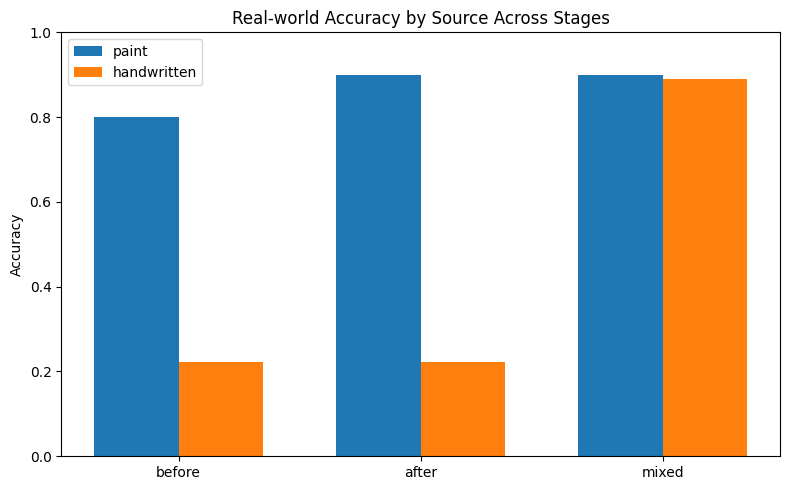

In [90]:
# --------------------------------------------------
# Phase 3 — Plot summary (paint vs handwritten across stages)
# --------------------------------------------------
# This chart summarizes REAL-WORLD performance across:
# - before: MNIST-only model
# - after : real-world-only fine-tuning
# - mixed : mixed fine-tuning (MNIST + real-world)
#
# For the "before" stage, we optionally filter rows with status == "ok"
# (if preprocessing failures are present).

import numpy as np
import matplotlib.pyplot as plt

def stage_accuracy_by_source(df_stage, stage_name):
    """
    Compute real-world accuracy for a given stage.

    Returns a dict with:
      - overall accuracy
      - accuracy by source: paint / handwritten
      - sample count (n)

    Notes:
    - If 'status' exists, we evaluate only status == "ok"
    - If 'correct' doesn't exist, we compute it from (pred == true)
    """
    d = df_stage.copy()

    # Only evaluate samples that successfully passed the pipeline
    if "status" in d.columns:
        d = d[d["status"] == "ok"].copy()

    # Ensure correctness column exists
    if "correct" not in d.columns:
        d["correct"] = (d["pred"] == d["true"]).astype(int)

    acc_overall = float(d["correct"].mean()) if len(d) else np.nan
    by_source = d.groupby("source")["correct"].mean().to_dict()

    return {
        "stage": stage_name,
        "overall": acc_overall,
        "paint": float(by_source.get("paint", np.nan)),
        "handwritten": float(by_source.get("handwritten", np.nan)),
        "n": len(d),
    }

def plot_accuracy_bars(stages_info, save_path=None):
    """
    Create grouped bar chart: paint vs handwritten accuracy per stage.
    If save_path is provided, the figure is saved as a PNG.
    """
    labels = [s["stage"] for s in stages_info]
    paint_vals = [s["paint"] for s in stages_info]
    hand_vals  = [s["handwritten"] for s in stages_info]

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, paint_vals, width, label="paint")
    plt.bar(x + width/2, hand_vals,  width, label="handwritten")

    plt.ylim(0, 1.0)
    plt.xticks(x, labels)
    plt.ylabel("Accuracy")
    plt.title("Real-world Accuracy by Source Across Stages")
    plt.legend()
    plt.tight_layout()

    # Save if requested
    if save_path is not None:
        plt.savefig(save_path, dpi=150)
        print(f"[SAVED] {save_path}")

    plt.show()

# --------------------------------------------------
# Build stage metrics table
# --------------------------------------------------
stages_info = [
    stage_accuracy_by_source(df, "before"),
    stage_accuracy_by_source(df_after, "after"),
    stage_accuracy_by_source(df_mixed, "mixed"),
]

acc_table = pd.DataFrame(stages_info)[["stage", "n", "overall", "paint", "handwritten"]]

# Show table + plot (useful for README and reporting)
display(acc_table)
plot_accuracy_bars(stages_info)


,stage,n,overall,paint,handwritten
0,before,19,0.526316,0.8,0.222222
1,after,19,0.578947,0.9,0.222222
2,mixed,19,0.894737,0.9,0.888889


[SAVED] /content/drive/MyDrive/real_world_digits/exports/accuracy_by_source.png


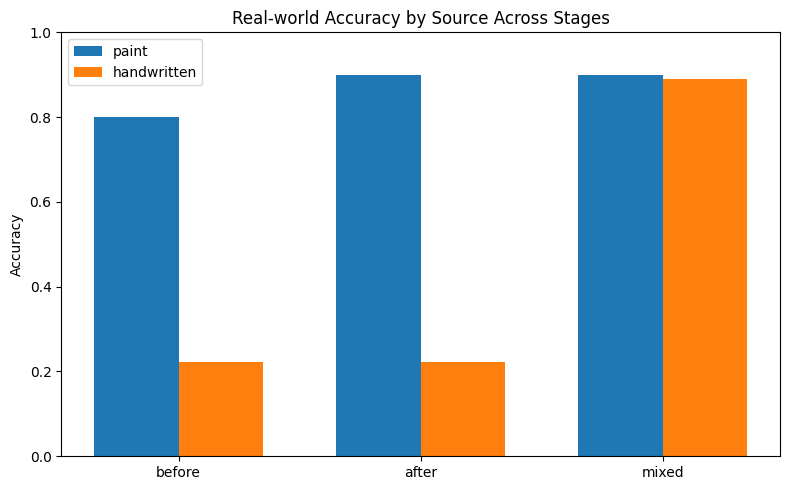

In [91]:
# Where to save the plot
PLOT_OUT_PATH = "/content/drive/MyDrive/real_world_digits/exports/accuracy_by_source.png"

# Show table (already created earlier)
display(acc_table)

# Plot + save
plot_accuracy_bars(stages_info, save_path=PLOT_OUT_PATH)
